**классификатор текстов LSTM + W2V**

Евгений Борисов <borisov.e@solarl.ru>

https://ruscorpora.ru/new/

https://nlpub.ru/Russian_Distributional_Thesaurus    

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200  
import re
import gc
# import gzip
from tqdm import tqdm

In [2]:
tqdm.pandas()

/usr/lib/python3.9/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [4]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [5]:
neg = pd.read_csv('../data/twit/negative.csv.gz',sep=';',header=None)
ppr(neg)
neg.columns = ff

записей: 111 923


In [6]:
pos = pd.read_csv('../data/twit/positive.csv.gz',sep=';')
ppr(pos)
pos.columns = ff

записей: 114 910


In [7]:
data = pd.concat([pos,neg],sort=False)[['id','ttext', 'ttype']]
ppr(data)

записей: 226 833


In [8]:
data.sample(10)

,id,ttext,ttype
99673,423078685889921025,"@drug_poison я хотел чтобы все знали или вспомнили что это я был, просто очень часто я всё менял(",-1
93292,410868701874126848,"RT @DubovikAlina: ЕЩЕ НЕ ВЫУЧИЛА СВ-ВА ВОДОРОДА ,А УЖЕ ДУМАЮ КУДА ПОЙДУ СДАВАТЬ БУТЫЛКИ:DDD",1
75798,418998669208481792,Жена не хочет секса :( http://t.co/TcaZ7wm1Z6,-1
84493,420461660785369088,"Бля,сейчас просто поняла,что моя Калина уедет надолго. Боя,капец товарищи:(",-1
24360,412001429889757184,RT @qimyqovojuv: Жаль что Windows Live Mail и Windows Live Writer не работают под Win 2k :( На работе было бы удобно ими пользоваться для,-1
89612,421604342362554368,"Экзамены.Боже,все было так хорошо.Мне кажется,мой мозг не может запоминать(",-1
64914,410363611111260160,все-таки самые поездатые на нем игры это эмулятор SMD и старые добрые ромы :) а это ваше три-дэ и управление датчиками на,1
28651,409617326687154176,RT @supermansosiska: Все нормально :D http://t.co/5PVUIQwUao,1
36143,413654233209380864,"проходит время,но к сожалению оно не лечит..(((",-1
78888,410725609640173568,У нас в садике творились какие-то мексиканские страсти :D,1


## очистка данных

In [9]:
data['ttext_clean'] = data['ttext']\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

100%|██████████| 226833/226833 [00:01<00:00, 121166.32it/s]


In [10]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [11]:
data['ttext_clean'] = data['ttext_clean'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|██████████| 226833/226833 [00:02<00:00, 105320.73it/s]


In [12]:
data.sample(3)

,id,ttext,ttype,ttext_clean
9164,410291068559958016,Нужно строить планы на новый год...( но почему то ощущения праздника совсем нет,-1,"[нужно, строить, планы, на, новый, год, но, почему, то, ощущения, праздника, совсем, нет]"
46310,414733998846664704,"В понедельник на рентген, а пока дома чай, молоко, мед и теплое одеяло :(",-1,"[в, понедельник, на, рентген, а, пока, дома, чай, молоко, мед, и, теплое, одеяло, sadsmile]"
20687,409417344927010816,"@butyrskaya99 @katyazhogal @Alina_kolc я зарегила алину в тви, \nя молодец)",1,"[katyazhogal, alina, kolc, я, зарегила, алину, в, тви, я, молодец]"


In [13]:
# удаление коротких слов
data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda t:[w for w in t if len(w)>2])

100%|██████████| 226833/226833 [00:00<00:00, 346984.14it/s]


In [14]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 226 833
записей: 226 831


In [15]:
data.sample(3)

,id,ttext,ttype,ttext_clean
205946,421838166388408320,"RT @kyxtyxa: Вообще, что за дела . Мужики как бабы ( цветочки вам, может?",-1,"[kyxtyxa, вообще, что, дела, мужики, как, бабы, цветочки, вам, может]"
45992,409991995256750080,Сегодня одноклассники на обществе устроили батхерт))) такие угарные))),1,"[сегодня, одноклассники, обществе, устроили, батхерт, happysmile, такие, угарные, happysmile]"
29357,409625928247963648,"Пока жду Юру,смотрю на мальчиков:\n-Ладно,Юр,давай едь,я пока на мальчиков посмотрю\n- -_-\n-Что?\n-Ты каждый день на них смотришь :DD\n-хахахах",1,"[пока, жду, юру, смотрю, мальчиков, ладно, давай, едь, пока, мальчиков, посмотрю, что, каждый, день, них, смотришь, happysmile, хахахах]"


In [16]:
# voc = sorted(set.union(*[ set(s) for s in data['ttext_clean'].values.tolist() ]))
# voc = { w:i+1 for i,w in enumerate(voc) }
# voc['<pad>']= 0
# ppr(voc)

## строим датасет

### кодируем word2vec

In [25]:
# %%time


# https://nlpub.ru/Russian_Distributional_Thesaurus
    
# from gensim.models import KeyedVectors 
# w2v_file = 'tenth.norm-sz500-w7-cb0-it5-min5.w2v'
# w2v = KeyedVectors.load_word2vec_format(w2v_file, binary=True, unicode_errors='ignore')
# w2v.init_sims(replace=True)

In [26]:
%%time

from gensim.models.word2vec import Word2Vec

w2v_size = 128

w2v = Word2Vec( data['ttext_clean'].values, min_count=1, size=w2v_size, window=4, workers=4)

# with open('result/Word2Vec.pkl', 'wb') as f: pickle.dump(w2v, f)

CPU times: user 1min 7s, sys: 320 ms, total: 1min 7s
Wall time: 40.1 s


In [27]:
w2v_vocab = sorted([w for w in w2v.wv.vocab])
ppr(w2v_vocab)

записей: 239 517


In [28]:
ii = np.random.permutation(len(w2v_vocab))[:30]
for i in ii:
    w = w2v_vocab[i]
    ww = [ v[0] for v in w2v.most_similar(w, topn=5) ]
    print( w,':',ww )

апреееель : ['зафикшена', 'спасииииииииииииба', 'xyxydesevyl', 'fypeqywupaz', 'задорнов']


<ipython-input-28-51489ecf273e>:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ww = [ v[0] for v in w2v.most_similar(w, topn=5) ]


ukesha : ['typikal', 'мэйл', 'экспертом', 'выбирая', 'штурмовать']
ideas : ['сергиев', 'следователь', 'pack', 'удаа', 'слів']
besties : ['ситкома', 'розес', 'твитдека', 'gainetdinov', 'хутина']
chistyakoway : ['сбудется', 'ellena', 'конечно', 'foreveralone', 'заход']
онем : ['рассказываем', 'джоани', 'ааахахахах', 'метаинфо', 'завернутым']
cream : ['turiindaisan', 'астахов', 'aka', 'екен', 'danil']
разобрался : ['парк', 'квартал', 'пень', 'динамо', 'win']
продлился : ['разбудиди', 'переворачивал', 'govoritdonetsk', 'конёк', 'kukolkalenaa']
davydoff : ['молоко', 'хахахах', 'ddddddd', 'чипсы', 'кул']
өрелі : ['slendy', 'жадноклассниках', 'қолибтилар', 'молоко', 'редакцию']
чёрта : ['лешего', 'урматы', 'спрашивается', 'штуку', 'usps']
бестселлера : ['прочитаешь', 'хобот', 'зарегана', 'прочлаааа', 'ордерочек']
споют : ['enemyzzz', 'nedeesposobnii', 'вратаря', 'джоггеров', 'возбуждать']
выбрось : ['изложить', 'переписать', 'покороче', 'сплёвывать', 'прекращать']
pornosporno : ['ненужных', '

In [29]:
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ w2v.wv.get_vector(w) for w in t ] )

100%|██████████| 226831/226831 [00:02<00:00, 96436.80it/s] 


In [30]:
%xdel w2v
%xdel w2v_vocab

In [31]:
code_max_len = data['code'].str.len().max()
code_max_len

32

In [32]:
data['code'].str.len().describe().astype(int)

count    226831
mean         10
std           3
min           1
25%           7
50%           9
75%          13
max          32
Name: code, dtype: int64

In [33]:
z = [[0.]*w2v_size]*code_max_len
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

100%|██████████| 226831/226831 [00:00<00:00, 348113.17it/s]


In [34]:
data['code'].str.len().describe().astype(int)

count    226831
mean         32
std           0
min          32
25%          32
50%          32
75%          32
max          32
Name: code, dtype: int64

In [35]:
data['code'] = data['code'].progress_apply(np.array)

100%|██████████| 226831/226831 [00:18<00:00, 12311.53it/s]


In [36]:
x = np.stack( data['code'].values )
x.shape

(226831, 32, 128)

In [37]:
x = np.flip(x,axis=1)

In [38]:
n_classes=2
target = data['ttype'].values
target = (target+1)//2
y = np.eye(n_classes)[target]

y.shape

(226831, 2)

In [39]:
%xdel data

In [40]:
gc.collect()

176

In [42]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=.4 )
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((136098, 32, 128), (136098, 2), (90733, 32, 128), (90733, 2))

In [43]:
y_train.sum(axis=0),y_test.sum(axis=0),

(array([67251., 68847.]), array([44671., 46062.]))

In [44]:
%xdel x
%xdel y

In [45]:
gc.collect()

45

## строим нейросеть 

In [55]:
seq_len = x_train.shape[1]
x_train.shape , y_train.shape, seq_len, w2v_size

((136098, 32, 128), (136098, 2), 32, 128)

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [57]:
model = Sequential()
model.add(LSTM(64, input_shape=(seq_len, w2v_size)))  
model.add(Dense(n_classes, activation='softmax'))

In [58]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

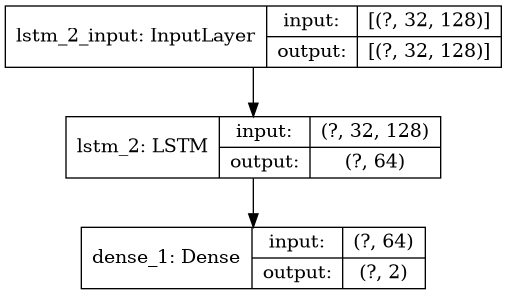

In [59]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_layer_names=True, show_shapes=True )

In [60]:
%%time

hist = model.fit(x_train,y_train, batch_size=1024, epochs=15, validation_split=.3)

Epoch 1/15
94/94 [==============================] - 2s 19ms/step - loss: 0.3987 - accuracy: 0.7930 - val_loss: 0.3349 - val_accuracy: 0.8329
Epoch 2/15
94/94 [==============================] - 1s 14ms/step - loss: 0.2593 - accuracy: 0.8614 - val_loss: 0.2406 - val_accuracy: 0.8688
Epoch 3/15
94/94 [==============================] - 1s 14ms/step - loss: 0.2377 - accuracy: 0.8705 - val_loss: 0.2315 - val_accuracy: 0.8721
Epoch 4/15
94/94 [==============================] - 1s 14ms/step - loss: 0.2292 - accuracy: 0.8737 - val_loss: 0.2272 - val_accuracy: 0.8737
Epoch 5/15
94/94 [==============================] - 1s 14ms/step - loss: 0.2245 - accuracy: 0.8774 - val_loss: 0.2394 - val_accuracy: 0.8655
Epoch 6/15
94/94 [==============================] - 1s 14ms/step - loss: 0.2239 - accuracy: 0.8781 - val_loss: 0.2261 - val_accuracy: 0.8740
Epoch 7/15
94/94 [==============================] - 1s 14ms/step - loss: 0.2200 - accuracy: 0.8806 - val_loss: 0.2251 - val_accuracy: 0.8756
Epoch 8/15
94

In [61]:
model.evaluate(x_test ,y_test )

2836/2836 [==============================] - 4s 1ms/step - loss: 0.2220 - accuracy: 0.8797


[0.22199736535549164, 0.8797019720077515]

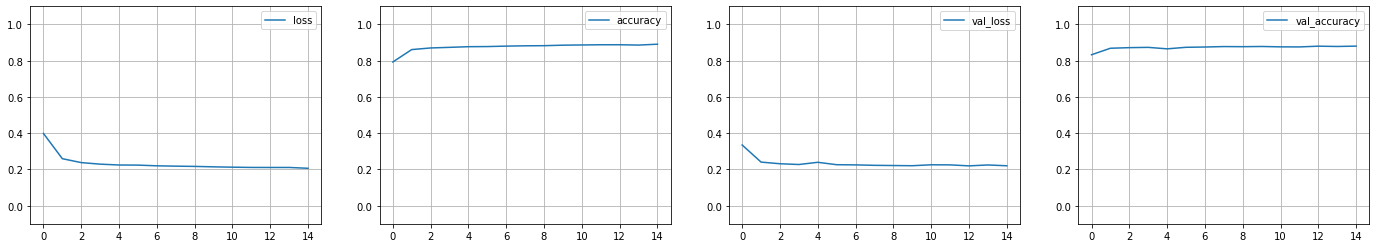

In [62]:
from matplotlib import pyplot as plt

k = hist.history.keys()

w,h = 6,4

fig,ax = plt.subplots(1,len(k),figsize=(w*len(k),h))
for i,n in enumerate(k):
    ax[i].plot(hist.history[n],label=n)
    ax[i].grid(True)
    ax[i].legend()
    ax[i].set_ylim([-.1,1.1])